<a href="https://colab.research.google.com/github/UygarUsta/Codes/blob/main/Cars_with_Retinanet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
get_ipython().system_raw("unrar x /content/drive/MyDrive/train_25class_marka.rar")

In [ ]:
from glob import glob

In [ ]:
path_ford = glob("/content/train_25class_marka/FORD/*.xml")
path_honda = glob("/content/train_25class_marka/HONDA/*.xml")
path = path_ford + path_honda


In [ ]:
from random import shuffle,seed
shuffle(path)

In [ ]:
import xml.etree.ElementTree as ET
from xml.dom.minidom import parse

for xmls in sorted(path):
    dom = parse(xmls)
    root = dom.documentElement
    split_path = "/".join(xmls.split("/")[:-1]) + "/"
    filename = root.getElementsByTagName("filename")[0].childNodes[0].data
    width = root.getElementsByTagName("width")[0].childNodes[0].data
    height = root.getElementsByTagName("height")[0].childNodes[0].data
    jpg = split_path+filename
    name = root.getElementsByTagName("name")[0].childNodes[0].data
    xmin = int(root.getElementsByTagName("xmin")[0].childNodes[0].data) 
    ymin = int(root.getElementsByTagName("ymin")[0].childNodes[0].data) 
    xmax = int(root.getElementsByTagName("xmax")[0].childNodes[0].data)  
    ymax = int(root.getElementsByTagName("ymax")[0].childNodes[0].data)  
    width = int(width)
    height = int(height)
    print((xmin/width)*224,(ymin/height)*224,(xmax/width)*224,(ymax/height)*224,jpg,width,height)
    break

6.122186495176849 28.47921760391198 176.10289389067526 134.7286063569682 /content/train_25class_marka/FORD/001348.jpg 622 409


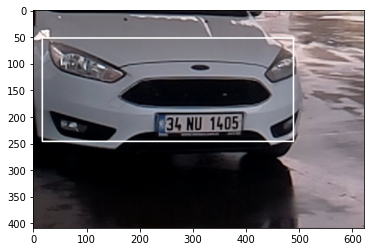

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/train_25class_marka/FORD/001348.jpg")
cv2.rectangle(img,(17,52),(489,246),(255, 255, 255), 2)
plt.imshow(img[...,::-1])

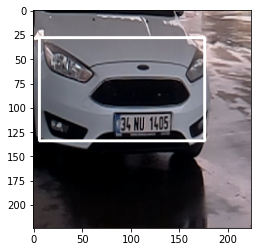

In [ ]:
img = cv2.imread("/content/train_25class_marka/FORD/001348.jpg")
img = cv2.resize(img,(224,224))
cv2.rectangle(img,(6,28),(176,134),(255, 255, 255), 2)
plt.imshow(img[...,::-1])

In [ ]:
!git clone https://github.com/pytorch/vision.git


Cloning into 'vision'...
remote: Enumerating objects: 31121, done.
remote: Counting objects: 100% (3664/3664), done.
remote: Compressing objects: 100% (849/849), done.
remote: Total 31121 (delta 2851), reused 3497 (delta 2744), pack-reused 27457
Receiving objects: 100% (31121/31121), 38.41 MiB | 30.52 MiB/s, done.
Resolving deltas: 100% (23467/23467), done.


In [ ]:
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

In [ ]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 6.9MB/s 
     |████████████████████████████████| 952kB 36.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65175 sha256=ed04e5d0b74b49ba017d0b1a0479c5e6ce7a699228d7192c38961bc5d86153a3
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV

# matplotlib for visualization
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
clx = [_,"FORD","HONDA"]
clx.index("FORD")

1

In [ ]:
class Cars(torch.utils.data.Dataset):
  def __init__(self,path,transforms = None):
    self.path = path
    self.transforms = transforms
    self.classes = [_,"FORD","HONDA"]
  def __len__(self):
    return len(self.path)
  def __getitem__(self,ix):
    img_name = self.path[ix].replace(".xml",".jpg")
    xml_name = self.path[ix]
    img = cv2.imread(img_name)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (224, 224), cv2.INTER_AREA)
    img_res /= 255.0
    boxes = []
    labels = []

    wt = img.shape[1]
    ht = img.shape[0]

    dom = parse(xml_name)
    root = dom.documentElement
    filename = root.getElementsByTagName("filename")[0].childNodes[0].data
    name = root.getElementsByTagName("name")[0].childNodes[0].data
    labels.append(self.classes.index(name))
    xmin = int(root.getElementsByTagName("xmin")[0].childNodes[0].data) 
    ymin = int(root.getElementsByTagName("ymin")[0].childNodes[0].data) 
    xmax = int(root.getElementsByTagName("xmax")[0].childNodes[0].data)  
    ymax = int(root.getElementsByTagName("ymax")[0].childNodes[0].data) 

    xmin_corr = (xmin/wt)*224
    xmax_corr = (xmax/wt)*224
    ymin_corr = (ymin/ht)*224
    ymax_corr = (ymax/ht)*224
    boxes.append([xmin_corr,ymin_corr,xmax_corr,ymax_corr])
    boxes = torch.as_tensor(boxes,dtype = torch.float32)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["area"] = area
    target["iscrowd"] = iscrowd
    image_id = torch.tensor([ix])
    target["image_id"] = image_id

    if self.transforms:


      sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])

    return img_res,target


In [ ]:
len(path)
train = path[:1350]
val = path[1350:]

In [ ]:
dataset = Cars(train)
im,target = dataset[14]

In [ ]:
target

{'area': tensor([17086.8105]),
 'boxes': tensor([[  8.3319,  18.6667, 215.0272, 101.3333]]),
 'image_id': tensor([14]),
 'iscrowd': tensor([0]),
 'labels': tensor([1])}

In [ ]:
def get_object_detection_model(num_classes):


  model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained = True)
    

  return model

In [ ]:
def get_transform(train):

    
  if train:
    return A.Compose([
                            A.HorizontalFlip(0.5),
                            A.RandomBrightnessContrast(p=0.2),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  else:
    return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
train_dataset = Cars(train,transforms=get_transform(train = True))
val_dataset = Cars(val,transforms = get_transform(train = False))

train_dl = torch.utils.data.DataLoader(
    train_dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

val_dl = torch.utils.data.DataLoader(
    val_dataset, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 3
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


In [ ]:
model

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_dl, device=device)

Epoch: [0]  [  0/135]  eta: 0:07:19  lr: 0.000042  loss: 3.5376 (3.5376)  classification: 2.8969 (2.8969)  bbox_regression: 0.6407 (0.6407)  time: 3.2591  data: 0.9806  max mem: 9515
Epoch: [0]  [ 10/135]  eta: 0:04:28  lr: 0.000415  loss: 1.9497 (2.2463)  classification: 1.3200 (1.6378)  bbox_regression: 0.6296 (0.6084)  time: 2.1443  data: 0.1122  max mem: 9772
Epoch: [0]  [ 20/135]  eta: 0:04:02  lr: 0.000788  loss: 1.2578 (1.6427)  classification: 0.7624 (1.1254)  bbox_regression: 0.5057 (0.5173)  time: 2.0536  data: 0.0261  max mem: 9772
Epoch: [0]  [ 30/135]  eta: 0:03:41  lr: 0.001161  loss: 0.7728 (1.3365)  classification: 0.4498 (0.8875)  bbox_regression: 0.3399 (0.4491)  time: 2.0964  data: 0.0270  max mem: 9772
Epoch: [0]  [ 40/135]  eta: 0:03:21  lr: 0.001533  loss: 0.6135 (1.1453)  classification: 0.3148 (0.7443)  bbox_regression: 0.2731 (0.4009)  time: 2.1359  data: 0.0273  max mem: 9772
Epoch: [0]  [ 50/135]  eta: 0:03:01  lr: 0.001906  loss: 0.5096 (1.0170)  classificat

In [ ]:
im,target = val_dataset[34]

In [ ]:
def torch_to_pil(img):

  return torchtrans.ToPILImage()(img).convert('RGB')


In [ ]:
model.eval()

with torch.no_grad():
  prediction = model([im.to(device)])[0]

print("Predicted #boxes:",len(prediction["labels"]))
print("Real #boxes:",len(target["labels"]))


Predicted #boxes: 1
Real #boxes: 1


In [ ]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  a.imshow(img)
  for box in (target):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
    a.add_patch(rect)
  plt.show()

Without NMS


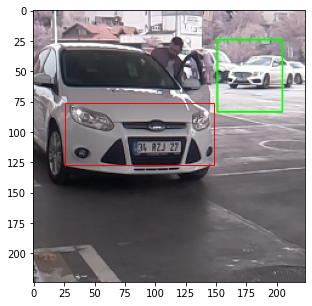

In [ ]:
print("Without NMS")
plot_img_bbox(torch_to_pil(im),prediction["boxes"])

In [ ]:
def nms(prediction,iou_thresh):
  best_box = len(prediction["scores"][prediction["scores"] > iou_thresh].cpu().numpy().tolist())
  bbox = prediction["boxes"][:best_box]
  best_score = prediction["scores"][:best_box]
  best_labels = prediction["labels"][:best_box]
  return bbox,best_score,best_labels

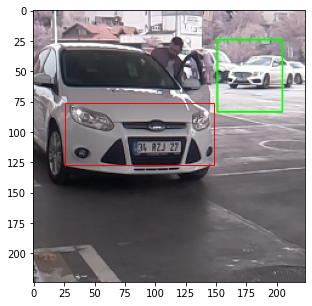

tensor([1], device='cuda:0')


In [ ]:
apply_nms = nms(prediction,0.186) #return bbox 
plot_img_bbox(torch_to_pil(im),apply_nms[0])
#print("Predicted is:",val_dataset.classes[nms(prediction,0.9)[2].cpu().numpy()[0]])
print(apply_nms[2])

In [ ]:
!wget https://i0.shbdn.com/photos/20/64/04/x5_936206404pvd.jpg

--2021-07-16 17:10:21--  https://i0.shbdn.com/photos/20/64/04/x5_936206404pvd.jpg
Resolving i0.shbdn.com (i0.shbdn.com)... 85.153.138.181
Connecting to i0.shbdn.com (i0.shbdn.com)|85.153.138.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 258052 (252K) [image/jpeg]
Saving to: ‘x5_936206404pvd.jpg’

x5_936206404pvd.jpg 100%[===================>] 252.00K   319KB/s    in 0.8s    

2021-07-16 17:10:24 (319 KB/s) - ‘x5_936206404pvd.jpg’ saved [258052/258052]



In [ ]:
from time import time
def predict(path,iou):

  img = cv2.imread(path)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
  img_res = cv2.resize(img_rgb, (224, 224), cv2.INTER_AREA)
  img_res /= 255.0
  img_res = torch.tensor(img_res).permute(2,0,1).float().to(device)
  model.eval()

  with torch.no_grad():
    s = time()
    prediction = model([img_res])[0]
    x = time()
  


  apply_nms = nms(prediction,iou) 
  nms_box = apply_nms[0]
  nms_score = apply_nms[1].cpu().numpy()
  nms_label = apply_nms[2].cpu().numpy()
  plot_img_bbox(img_res.cpu().permute(1,2,0).numpy(),nms_box)
  print("\nfps",1 / (x - s))
  print("label:{},score:{}".format(nms_label,nms_score))
  

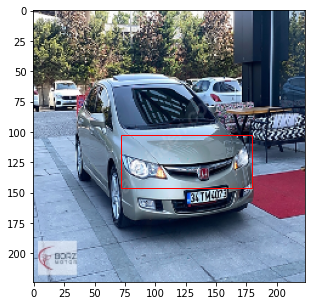


fps 7.0345782997143775
label:[2],score:[0.9742576]
Index 1:FORD,Index 2:HONDA


In [ ]:
predict("/content/x5_936206404pvd.jpg",0.185)
print("Index 1:{},Index 2:{}".format(clx[1],clx[2]))

In [ ]:
!wget https://i.ytimg.com/vi/YsMKuSy5oKk/maxresdefault.jpg

--2021-07-16 17:12:10--  https://i.ytimg.com/vi/YsMKuSy5oKk/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 142.250.141.119, 142.251.2.119, 172.217.3.54, ...
Connecting to i.ytimg.com (i.ytimg.com)|142.250.141.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190431 (186K) [image/jpeg]
Saving to: ‘maxresdefault.jpg’

maxresdefault.jpg   100%[===================>] 185.97K  --.-KB/s    in 0.1s    

2021-07-16 17:12:10 (1.43 MB/s) - ‘maxresdefault.jpg’ saved [190431/190431]



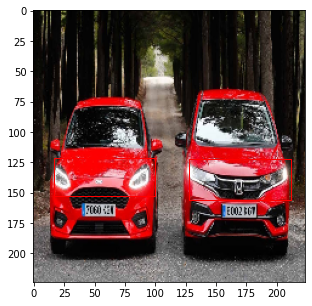


fps 6.982720932826565
label:[2 1],score:[0.96597123 0.7593838 ]


In [ ]:
predict("/content/maxresdefault.jpg",0.185)

In [ ]:
torch.save(model.state_dict(), "./retinanet.pth")